# Loan Default — EDA Only
Run this top-to-bottom. It loads data, handles the notice header, inspects schema/missingness, parses string numerics, plots distributions, computes default rate by buckets, checks leakage, and (optional) runs a baseline LR.

In [1]:

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

def smart_read_csv(p: Path) -> pd.DataFrame:
    with open(p, 'r', encoding='utf-8', errors='ignore') as f:
        first = f.readline()
        second = f.readline()
    return pd.read_csv(p, skiprows=1) if ('bad_flag' in second and 'bad_flag' not in first) else pd.read_csv(p)

# Candidate paths so this notebook works in notebooks/ or repo root
train_candidates = [Path('../data/training_loan_data.csv'), Path('./data/training_loan_data.csv'), Path('training_loan_data.csv')]
test_candidates  = [Path('../data/testing_loan_data.csv'),  Path('./data/testing_loan_data.csv'),  Path('testing_loan_data.csv')]

def pick_first_existing(paths):
    for p in paths:
        if p.exists():
            return p
    return None

train_path = pick_first_existing(train_candidates)
test_path  = pick_first_existing(test_candidates)
print("Using train path:", train_path)
print("Using test  path:", test_path)
if train_path is None:
    raise FileNotFoundError("Could not find training_loan_data.csv. Put it in repo_root/data/.")

df = smart_read_csv(train_path)
df.head()


Using train path: ..\data\training_loan_data.csv
Using test  path: ..\data\testing_loan_data.csv


,id,member_id,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,desc,purpose,percent_bc_gt_75,bc_util,dti,inq_last_6mths,mths_since_recent_inq,revol_util,total_bc_limit,mths_since_last_major_derog,tot_hi_cred_lim,tot_cur_bal,application_approved_flag,internal_score,bad_flag
0,10000001,11983056.0,7550,36 months,16.24%,3 years,RENT,28000.0,NaN,debt_consolidation,100.0,96.0,8.40,0.0,17.0,72%,4000.0,NaN,3828.953801,5759.0,1,99,0.0
1,10000002,12002921.0,27050,36 months,10.99%,10+ years,OWN,55000.0,Borrower added on 12/31/13 > Combining high ...,debt_consolidation,25.0,53.9,22.87,0.0,8.0,61.20%,35700.0,NaN,34359.940730,114834.0,1,353,0.0
2,10000003,11983096.0,12000,36 months,10.99%,4 years,RENT,60000.0,Borrower added on 12/31/13 > I would like to...,debt_consolidation,0.0,15.9,4.62,1.0,3.0,24%,18100.0,NaN,16416.617760,7137.0,1,157,0.0
3,10000004,12003142.0,28000,36 months,7.62%,5 years,MORTGAGE,325000.0,NaN,debt_consolidation,16.7,67.1,18.55,1.0,3.0,54.60%,42200.0,NaN,38014.149760,799592.0,1,365,0.0
4,10000005,11993233.0,12000,36 months,13.53%,10+ years,RENT,40000.0,NaN,debt_consolidation,33.3,79.6,16.94,0.0,17.0,68.80%,7000.0,53.0,6471.462236,13605.0,1,157,0.0


## 1) Shape & Schema

In [2]:

print("Shape:", df.shape)
df.info()


Shape: (199121, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199121 entries, 0 to 199120
Data columns (total 23 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           199121 non-null  int64  
 1   member_id                    189457 non-null  float64
 2   loan_amnt                    199121 non-null  int64  
 3   term                         189457 non-null  object 
 4   int_rate                     189457 non-null  object 
 5   emp_length                   181531 non-null  object 
 6   home_ownership               189457 non-null  object 
 7   annual_inc                   189457 non-null  float64
 8   desc                         82004 non-null   object 
 9   purpose                      189457 non-null  object 
 10  percent_bc_gt_75             180419 non-null  float64
 11  bc_util                      180333 non-null  float64
 12  dti                          189457 no

In [3]:
df.describe(include='all').T.head(30)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,199121.0,NaN,NaN,NaN,10098566.911205,57043.972099,10000001.0,10049582.0,10098227.0,10148007.0,10197787.0
member_id,189457.0,NaN,NaN,NaN,5929625.920367,3339821.824345,151536.0,2308792.0,6060627.0,8727745.0,12098992.0
loan_amnt,199121.0,NaN,NaN,NaN,14071.947334,8067.076636,1000.0,8000.0,12000.0,19600.0,35000.0
term,189457,2,36 months,144800,NaN,NaN,NaN,NaN,NaN,NaN,NaN
int_rate,189457,145,12.12%,9408,NaN,NaN,NaN,NaN,NaN,NaN,NaN
emp_length,181531,11,10+ years,61648,NaN,NaN,NaN,NaN,NaN,NaN,NaN
home_ownership,189457,5,MORTGAGE,97647,NaN,NaN,NaN,NaN,NaN,NaN,NaN
annual_inc,189457.0,NaN,NaN,NaN,72243.300905,51804.829944,4800.0,45000.0,62000.0,87000.0,7141778.0
desc,82004,80643,Borrower added on 09/05/13 > Debt consolidat...,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
purpose,189457,13,debt_consolidation,112259,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2) Target Balance & Cleaning

In [4]:

y_raw = pd.to_numeric(df['bad_flag'], errors='coerce')
mask = y_raw.isin([0.0, 1.0])
print("Rows dropped due to invalid/missing bad_flag:", int((~mask).sum()))

df_eda = df.loc[mask].copy()
df_eda['bad_flag'] = y_raw.loc[mask].astype(int)

print("\nCounts:")
print(df_eda['bad_flag'].value_counts())
print("\nProportions:")
print((df_eda['bad_flag'].value_counts(normalize=True)*100).round(2).astype(str) + "%")


Rows dropped due to invalid/missing bad_flag: 9664

Counts:
bad_flag
0    176329
1     13128
Name: count, dtype: int64

Proportions:
bad_flag
0    93.07%
1     6.93%
Name: proportion, dtype: object


In [5]:
# === Leakage-safe baseline: run this RIGHT AFTER your df_eda cell ===
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Use the cleaned frame you just created
df_model = df_eda.copy()

# target
y = df_model['bad_flag'].astype(int)

# columns we will NOT feed to the model (ids, text blobs, target, and potential leakage)
drop_cols = [
    'bad_flag','_bad_num','application_approved_flag','internal_score',  # leakage/target
    'id','member_id','desc','term'                                       # ids/text/raw term
]

# features expected from your parsing step
num_cols = [
    'loan_amnt','int_rate_num','revol_util_num','percent_bc_gt_75','bc_util','dti',
    'inq_last_6mths','emp_length_years','annual_inc','tot_hi_cred_lim',
    'total_bc_limit','tot_cur_bal','mths_since_recent_inq','term_months'
]
cat_cols = ['home_ownership','purpose']

# keep only columns that exist
num_cols = [c for c in num_cols if c in df_model.columns]
cat_cols = [c for c in cat_cols if c in df_model.columns]

# split BEFORE any fitting
X_idx_train, X_idx_val, y_train, y_val = train_test_split(
    df_model.index, y, test_size=0.2, random_state=42, stratify=y
)
train_df = df_model.loc[X_idx_train].drop(columns=[c for c in drop_cols if c in df_model.columns], errors='ignore')
val_df   = df_model.loc[X_idx_val].drop(columns=[c for c in drop_cols if c in df_model.columns], errors='ignore')

X_train = train_df[num_cols + cat_cols]
X_val   = val_df[num_cols + cat_cols]

preproc = ColumnTransformer([
    ('num', Pipeline([
        ('imp', SimpleImputer(strategy='median')),
        ('sc', StandardScaler())
    ]), num_cols),
    ('cat', Pipeline([
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols)
])

pipe = Pipeline([
    ('preproc', preproc),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear'))
])

pipe.fit(X_train, y_train)
pred_val = pipe.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, pred_val)
print(f"Leakage-safe Validation AUC: {auc:.4f}")



Leakage-safe Validation AUC: 0.6523


## 3) Missingness

In [6]:

missing = df_eda.isna().mean().sort_values(ascending=False)
display(missing.head(20).to_frame("missing_ratio"))


,missing_ratio
mths_since_last_major_derog,0.827143
desc,0.567163
mths_since_recent_inq,0.147712
tot_cur_bal,0.146424
bc_util,0.048159
percent_bc_gt_75,0.047705
emp_length,0.041835
total_bc_limit,0.039560
tot_hi_cred_lim,0.039560
revol_util,0.000670


## 4) Numeric vs Categorical

In [7]:

num_cols = df_eda.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_eda.select_dtypes(exclude=[np.number]).columns.tolist()
print("Numeric (sample):", num_cols[:12])
print("Categorical (sample):", cat_cols[:12])


Numeric (sample): ['id', 'member_id', 'loan_amnt', 'annual_inc', 'percent_bc_gt_75', 'bc_util', 'dti', 'inq_last_6mths', 'mths_since_recent_inq', 'total_bc_limit', 'mths_since_last_major_derog', 'tot_hi_cred_lim']
Categorical (sample): ['term', 'int_rate', 'emp_length', 'home_ownership', 'desc', 'purpose', 'revol_util']


## 5) Parse String Numerics (EDA-only helper columns)

In [8]:

def to_float_pct(s: pd.Series):
    return pd.to_numeric(s.astype(str).str.rstrip('%'), errors='coerce')

def to_int_months(s: pd.Series):
    return pd.to_numeric(s.astype(str).str.extract(r'(\d+)')[0], errors='coerce')

def parse_emp_length_years(s: pd.Series):
    s = s.astype(str).str.lower()
    years = pd.to_numeric(s.str.extract(r'(\d+)')[0], errors='coerce')
    years[s.str.contains('<', na=False)] = 0
    return years

if 'int_rate' in df_eda.columns:
    df_eda['int_rate_num'] = to_float_pct(df_eda['int_rate'])
if 'revol_util' in df_eda.columns:
    df_eda['revol_util_num'] = to_float_pct(df_eda['revol_util'])
if 'term' in df_eda.columns:
    df_eda['term_months'] = to_int_months(df_eda['term'])
if 'emp_length' in df_eda.columns:
    df_eda['emp_length_years'] = parse_emp_length_years(df_eda['emp_length'])

df_eda[['int_rate','int_rate_num','revol_util','revol_util_num','term','term_months','emp_length','emp_length_years']].head(8)


,int_rate,int_rate_num,revol_util,revol_util_num,term,term_months,emp_length,emp_length_years
0,16.24%,16.24,72%,72.0,36 months,36,3 years,3.0
1,10.99%,10.99,61.20%,61.2,36 months,36,10+ years,10.0
2,10.99%,10.99,24%,24.0,36 months,36,4 years,4.0
3,7.62%,7.62,54.60%,54.6,36 months,36,5 years,5.0
4,13.53%,13.53,68.80%,68.8,36 months,36,10+ years,10.0
5,22.90%,22.90,70.90%,70.9,60 months,60,4 years,4.0
6,10.99%,10.99,16.10%,16.1,36 months,36,2 years,2.0
7,9.67%,9.67,44.40%,44.4,36 months,36,7 years,7.0


## 6) Distributions

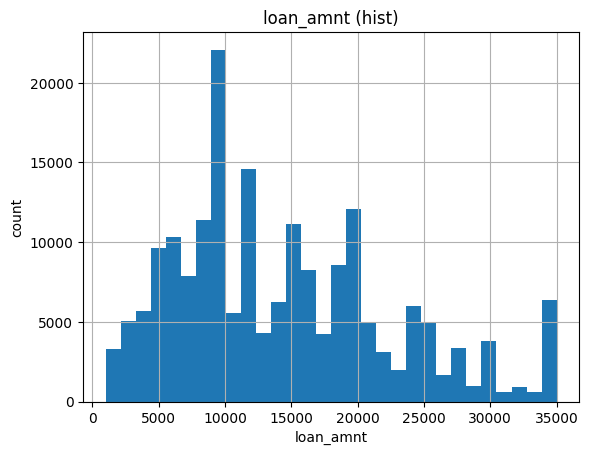

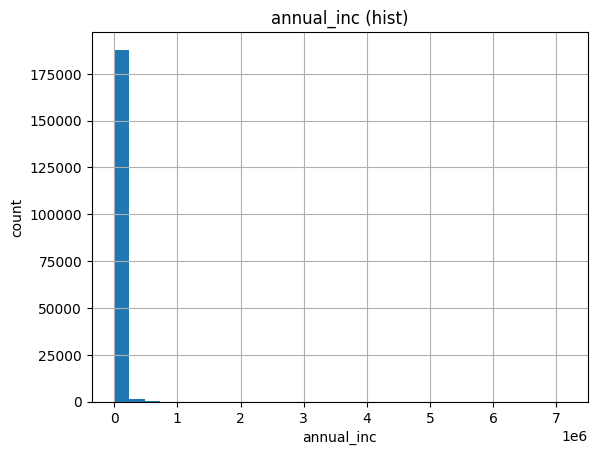

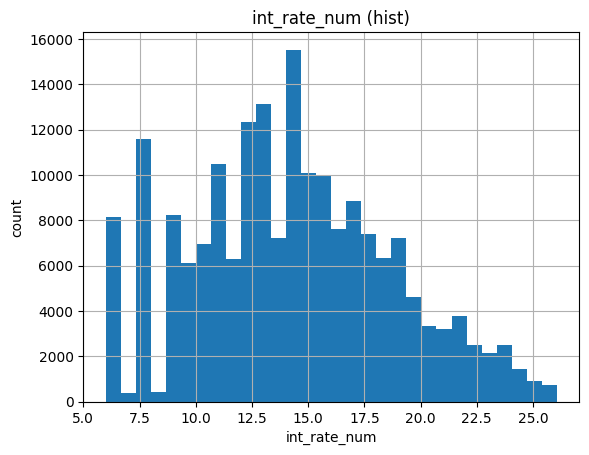

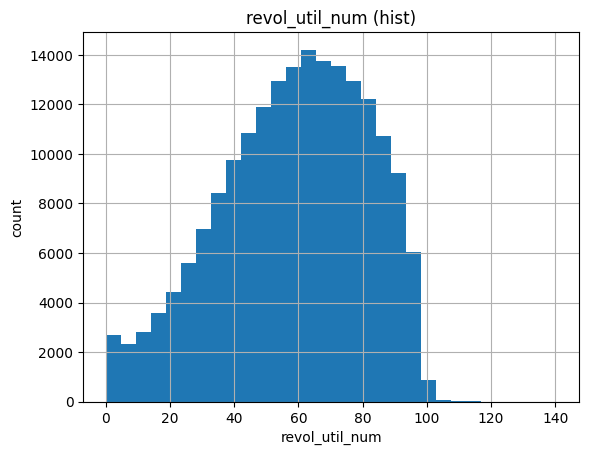

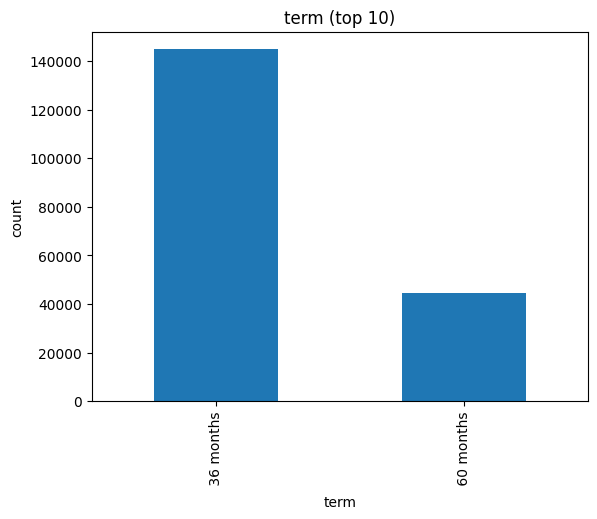

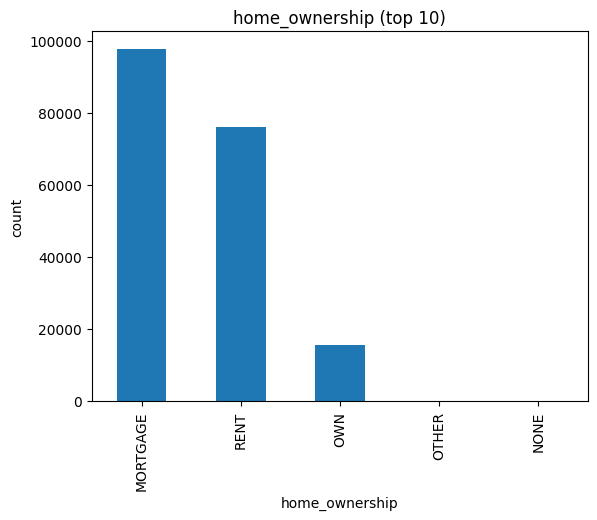

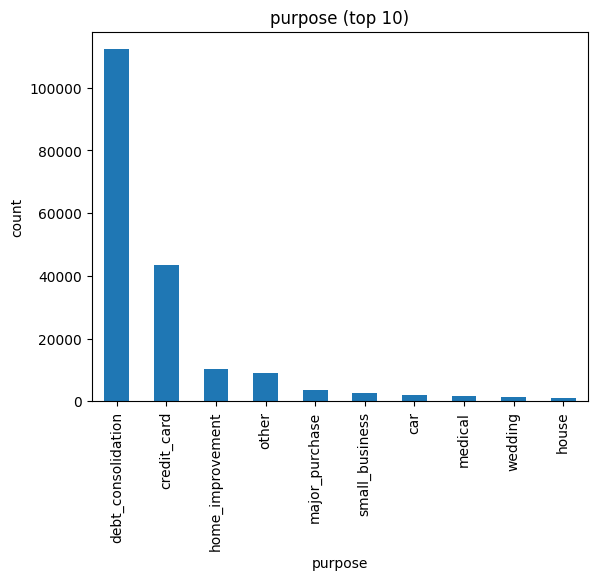

In [9]:

# Numeric histograms
plot_cols = [c for c in ['loan_amnt','annual_inc','int_rate_num','revol_util_num'] if c in df_eda.columns]
for c in plot_cols:
    plt.figure()
    df_eda[c].dropna().hist(bins=30)
    plt.title(f"{c} (hist)")
    plt.xlabel(c); plt.ylabel("count")
    plt.show()

# Categorical bars (top levels)
for c in [c for c in ['term','home_ownership','purpose'] if c in df_eda.columns]:
    plt.figure()
    df_eda[c].value_counts().head(10).plot(kind='bar')
    plt.title(f"{c} (top 10)")
    plt.xlabel(c); plt.ylabel("count")
    plt.show()


## 7) Default Rate by Buckets / Groups

In [10]:

def rate_by_bucket(df_in, col, bins=10):
    x = pd.qcut(df_in[col].dropna(), q=bins, duplicates='drop')
    tmp = (
        df_in.loc[df_in[col].notna(), :]
             .assign(bucket=x)
             .groupby('bucket', observed=True)['bad_flag']
             .mean()
             .rename('default_rate')
             .reset_index()
    )
    return tmp

# Numeric bucket examples
for col in ['int_rate_num','revol_util_num','loan_amnt']:
    if col in df_eda.columns:
        display(rate_by_bucket(df_eda, col, bins=10).style.format({'default_rate': '{:.3f}'}))

# Categorical example
if 'home_ownership' in df_eda.columns:
    cat_rate = (
        df_eda.groupby('home_ownership')['bad_flag']
              .mean()
              .sort_values(ascending=False)
              .rename('default_rate')
              .reset_index()
    )
    display(cat_rate.style.format({'default_rate': '{:.3f}'}))


,bucket,default_rate
0,"(5.999, 7.9]",0.028
1,"(7.9, 10.16]",0.036
2,"(10.16, 11.99]",0.035
3,"(11.99, 13.05]",0.055
4,"(13.05, 14.09]",0.073
5,"(14.09, 15.31]",0.068
6,"(15.31, 16.29]",0.076
7,"(16.29, 18.25]",0.090
8,"(18.25, 20.31]",0.109
9,"(20.31, 26.06]",0.129


,bucket,default_rate
0,"(-0.001, 26.1]",0.055
1,"(26.1, 38.0]",0.059
2,"(38.0, 46.6]",0.057
3,"(46.6, 53.9]",0.063
4,"(53.9, 60.5]",0.065
5,"(60.5, 66.8]",0.071
6,"(66.8, 73.2]",0.073
7,"(73.2, 80.0]",0.078
8,"(80.0, 87.7]",0.080
9,"(87.7, 140.4]",0.092


,bucket,default_rate
0,"(999.999, 5000.0]",0.072
1,"(5000.0, 7125.0]",0.064
2,"(7125.0, 9325.0]",0.071
3,"(9325.0, 10275.0]",0.067
4,"(10275.0, 12175.0]",0.063
5,"(12175.0, 15000.0]",0.064
6,"(15000.0, 18000.0]",0.076
7,"(18000.0, 20950.0]",0.072
8,"(20950.0, 25050.0]",0.063
9,"(25050.0, 35000.0]",0.082


,home_ownership,default_rate
0,OTHER,0.109
1,NONE,0.095
2,RENT,0.083
3,OWN,0.070
4,MORTGAGE,0.058


## 8) Numeric Correlations with Target

In [11]:

df_eda['_bad_num'] = df_eda['bad_flag'].astype(float)
corr = df_eda.select_dtypes(include=[np.number]).corr(numeric_only=True)['_bad_num'].sort_values(ascending=False)
print("Top correlations with target:")
display(corr.head(15).to_frame('corr'))
print("Bottom correlations with target:")
display(corr.tail(15).to_frame('corr'))


Top correlations with target:


,corr
bad_flag,1.000000
_bad_num,1.000000
id,0.140583
int_rate_num,0.120711
inq_last_6mths,0.059158
percent_bc_gt_75,0.048621
bc_util,0.042832
revol_util_num,0.041103
dti,0.039641
term_months,0.038078


Bottom correlations with target:


,corr
bc_util,0.042832
revol_util_num,0.041103
dti,0.039641
term_months,0.038078
loan_amnt,0.009112
internal_score,0.009109
mths_since_last_major_derog,-0.002508
emp_length_years,-0.021267
tot_cur_bal,-0.039655
annual_inc,-0.041267


## 9) Leakage Scan (be cautious!)

In [12]:

for c in ['application_approved_flag','internal_score']:
    if c in df_eda.columns:
        print(f"\n=== Potential leakage check: {c} ===")
        tmp = (
            df_eda.groupby(c, dropna=False)['bad_flag']
                  .mean()
                  .rename('default_rate')
                  .reset_index()
        )
        display(tmp.style.format({'default_rate': '{:.3f}'}))



=== Potential leakage check: application_approved_flag ===


,application_approved_flag,default_rate
0,1,0.069



=== Potential leakage check: internal_score ===


,internal_score,default_rate
0,14,0.063
1,15,0.000
2,16,0.083
3,17,0.072
4,18,0.000
5,19,0.111
6,20,0.026
7,21,0.078
8,22,0.047
9,23,0.062


## 10) Data Hygiene Checks

In [13]:

# Duplicated ids
if 'id' in df_eda.columns:
    dup_count = int(df_eda['id'].duplicated().sum())
    print("Duplicate ids:", dup_count)

# Near-constant columns (<= 2 unique values)
few_uniques = {c: df_eda[c].nunique(dropna=False) for c in df_eda.columns}
few_uniques = {k:v for k,v in few_uniques.items() if v <= 2}
few_uniques


Duplicate ids: 1334


{'term': 2,
 'application_approved_flag': 1,
 'bad_flag': 2,
 'term_months': 2,
 '_bad_num': 2}

---
## Optional: Baseline Logistic Regression (sanity check)

In [14]:

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import sklearn
from packaging import version

X = df_eda.drop(columns=['bad_flag']).copy()
for drop_col in ['member_id', 'desc']:
    if drop_col in X.columns:
        X.drop(columns=[drop_col], inplace=True)
y = df_eda['bad_flag'].astype(int)

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

num_t = Pipeline([('imp', SimpleImputer(strategy='median')),
                  ('scaler', StandardScaler())])

if version.parse(sklearn.__version__) < version.parse("1.3"):
    cat_t = Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                      ('oh', OneHotEncoder(handle_unknown='ignore', sparse=False))])
else:
    cat_t = Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                      ('oh', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

pre = ColumnTransformer([('num', num_t, num_cols),
                         ('cat', cat_t, cat_cols)])

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf = Pipeline([('pre', pre), ('lr', LogisticRegression(max_iter=1000))])
clf.fit(X_train, y_train)
prob = clf.predict_proba(X_valid)[:, 1]
auc = roc_auc_score(y_valid, prob)
print(f"Baseline Logistic Regression - Validation AUC: {auc:.4f}")


Baseline Logistic Regression - Validation AUC: 1.0000


---
## EDA Wrap-up (fill these bullets)
- Rows/columns; notable dtypes; string numerics parsed.
- Target is imbalanced: ~X% positive.
- Top missing columns and likely action (e.g., drop free-text `desc`).
- Key distributions: e.g., right-skewed `annual_inc`; `term` mostly 36 months.
- Default-rate patterns: higher `int_rate_num` / `revol_util_num` → higher default.
- Potential leakage: `application_approved_flag` / `internal_score` flagged for caution.
- (Optional) Baseline LR AUC: record value above.
